In [1]:
!pip install category_encoders

# Imports

In [2]:
# Import data handling libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder

# Modeling libs
from sklearn.model_selection import cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix
import joblib

# Remove warinings
import warnings
warnings.filterwarnings('ignore')

# Loading the data and explore it

In [3]:
df = pd.read_csv('/content/first inten project.csv')

df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [4]:
df.shape

(36285, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [6]:
df.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [7]:
# find duplicates
df.duplicated().sum()

0

# Feature Engineering

In [8]:
# Delete the Booking_ID column
df.drop(columns=['Booking_ID'], inplace=True)

In [9]:
# Convert the date of reservation column to a datetime format
df['date of reservation'] = pd.to_datetime(df['date of reservation'], errors='coerce')

In [10]:
# Extract non-numerical columns
non_numerical_columns = df.select_dtypes(exclude=['number', 'datetime']).columns.tolist()

# Print the non-numerical columns
print(f'Non-Numerical Columns:{non_numerical_columns}')
print("-"*50)

# Get the unique values for each column
for column in non_numerical_columns:
    unique_values = df[column].unique()
    print(f'Unique values for {column} column:')
    print(unique_values)
    print("-"*50)

Non-Numerical Columns:['type of meal', 'room type', 'market segment type', 'booking status']
--------------------------------------------------
Unique values for type of meal column:
['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']
--------------------------------------------------
Unique values for room type column:
['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
--------------------------------------------------
Unique values for market segment type column:
['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']
--------------------------------------------------
Unique values for booking status column:
['Not_Canceled' 'Canceled']
--------------------------------------------------


In [11]:
# Encoding Target column
replacement_dict = {'Not_Canceled': 1, 'Canceled': 0}
df['booking status'] = df['booking status'].replace(replacement_dict)

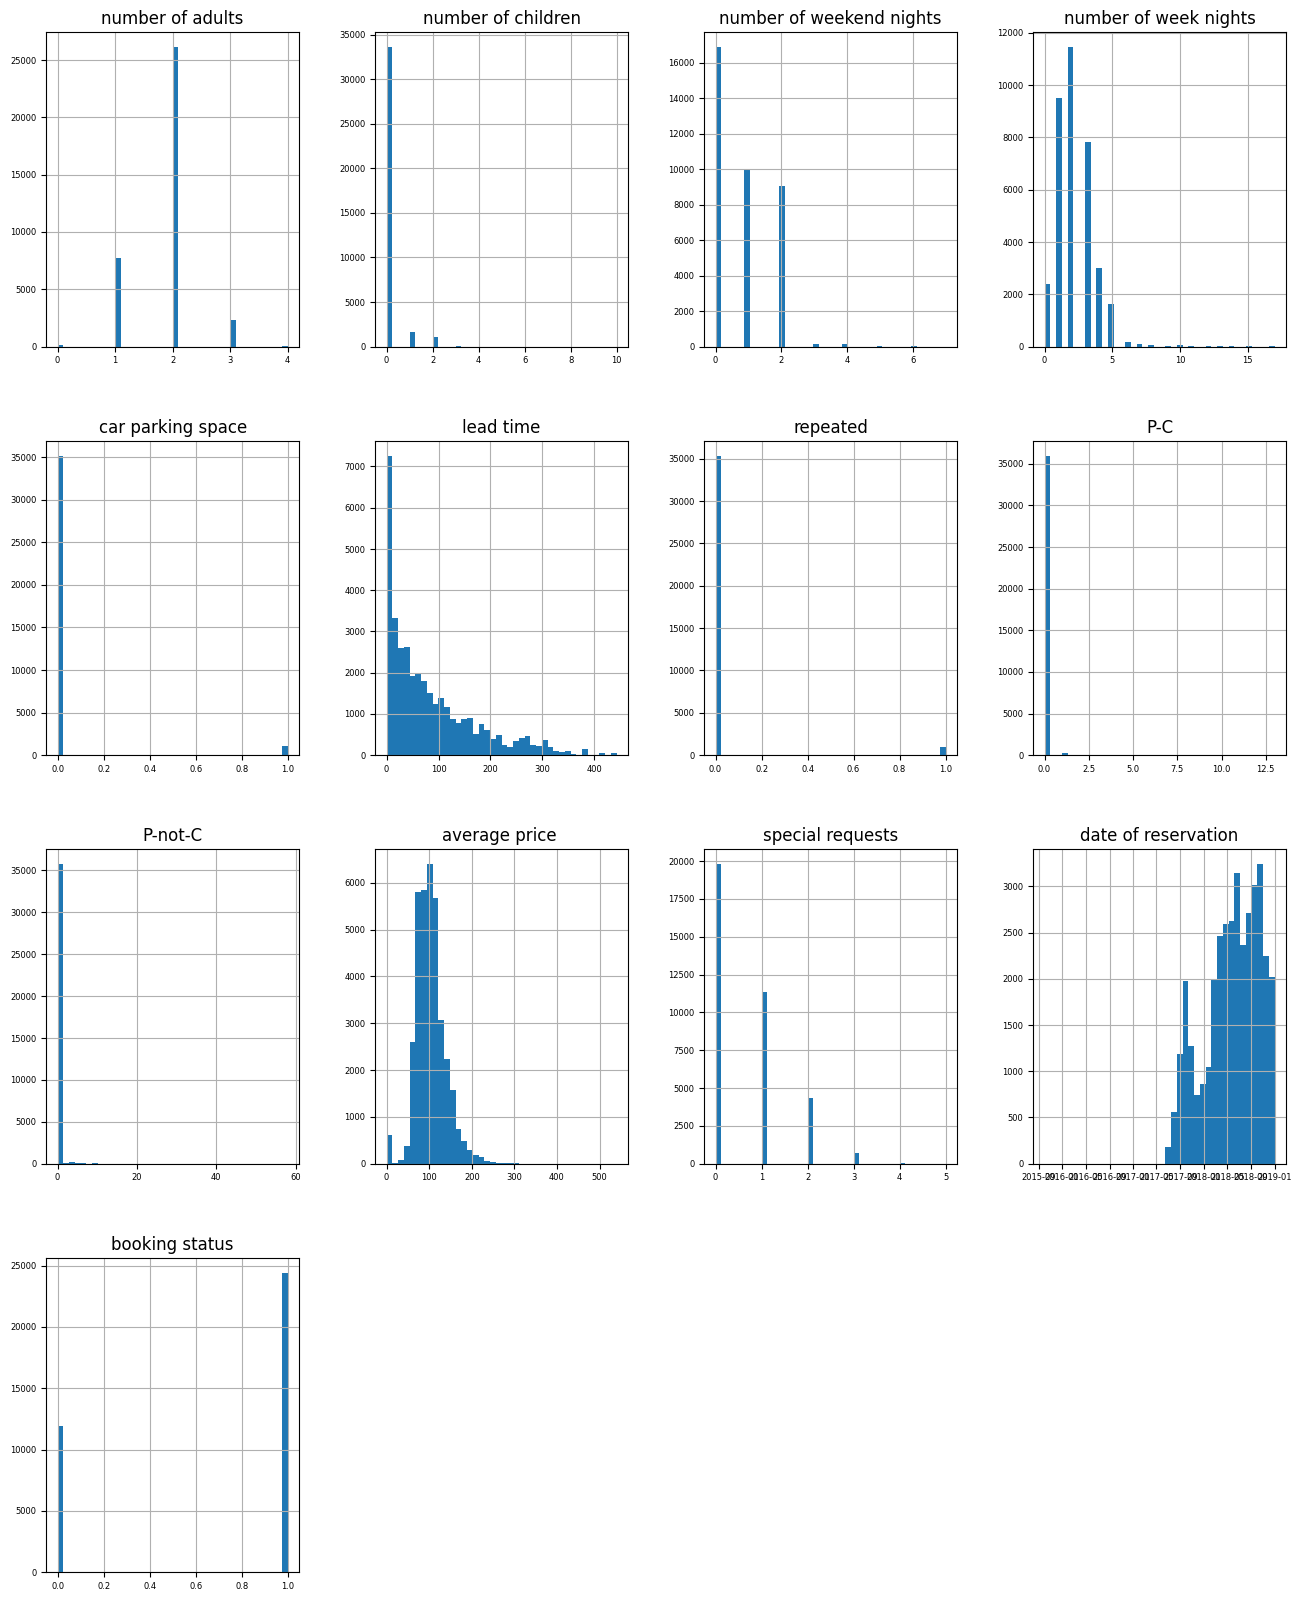

In [12]:
# Data distribution of the numerical columns
df_num = df.select_dtypes(include=['number'])
df.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6);

- check the outliers
- The average price has zeros !!!
- Date of reservation column

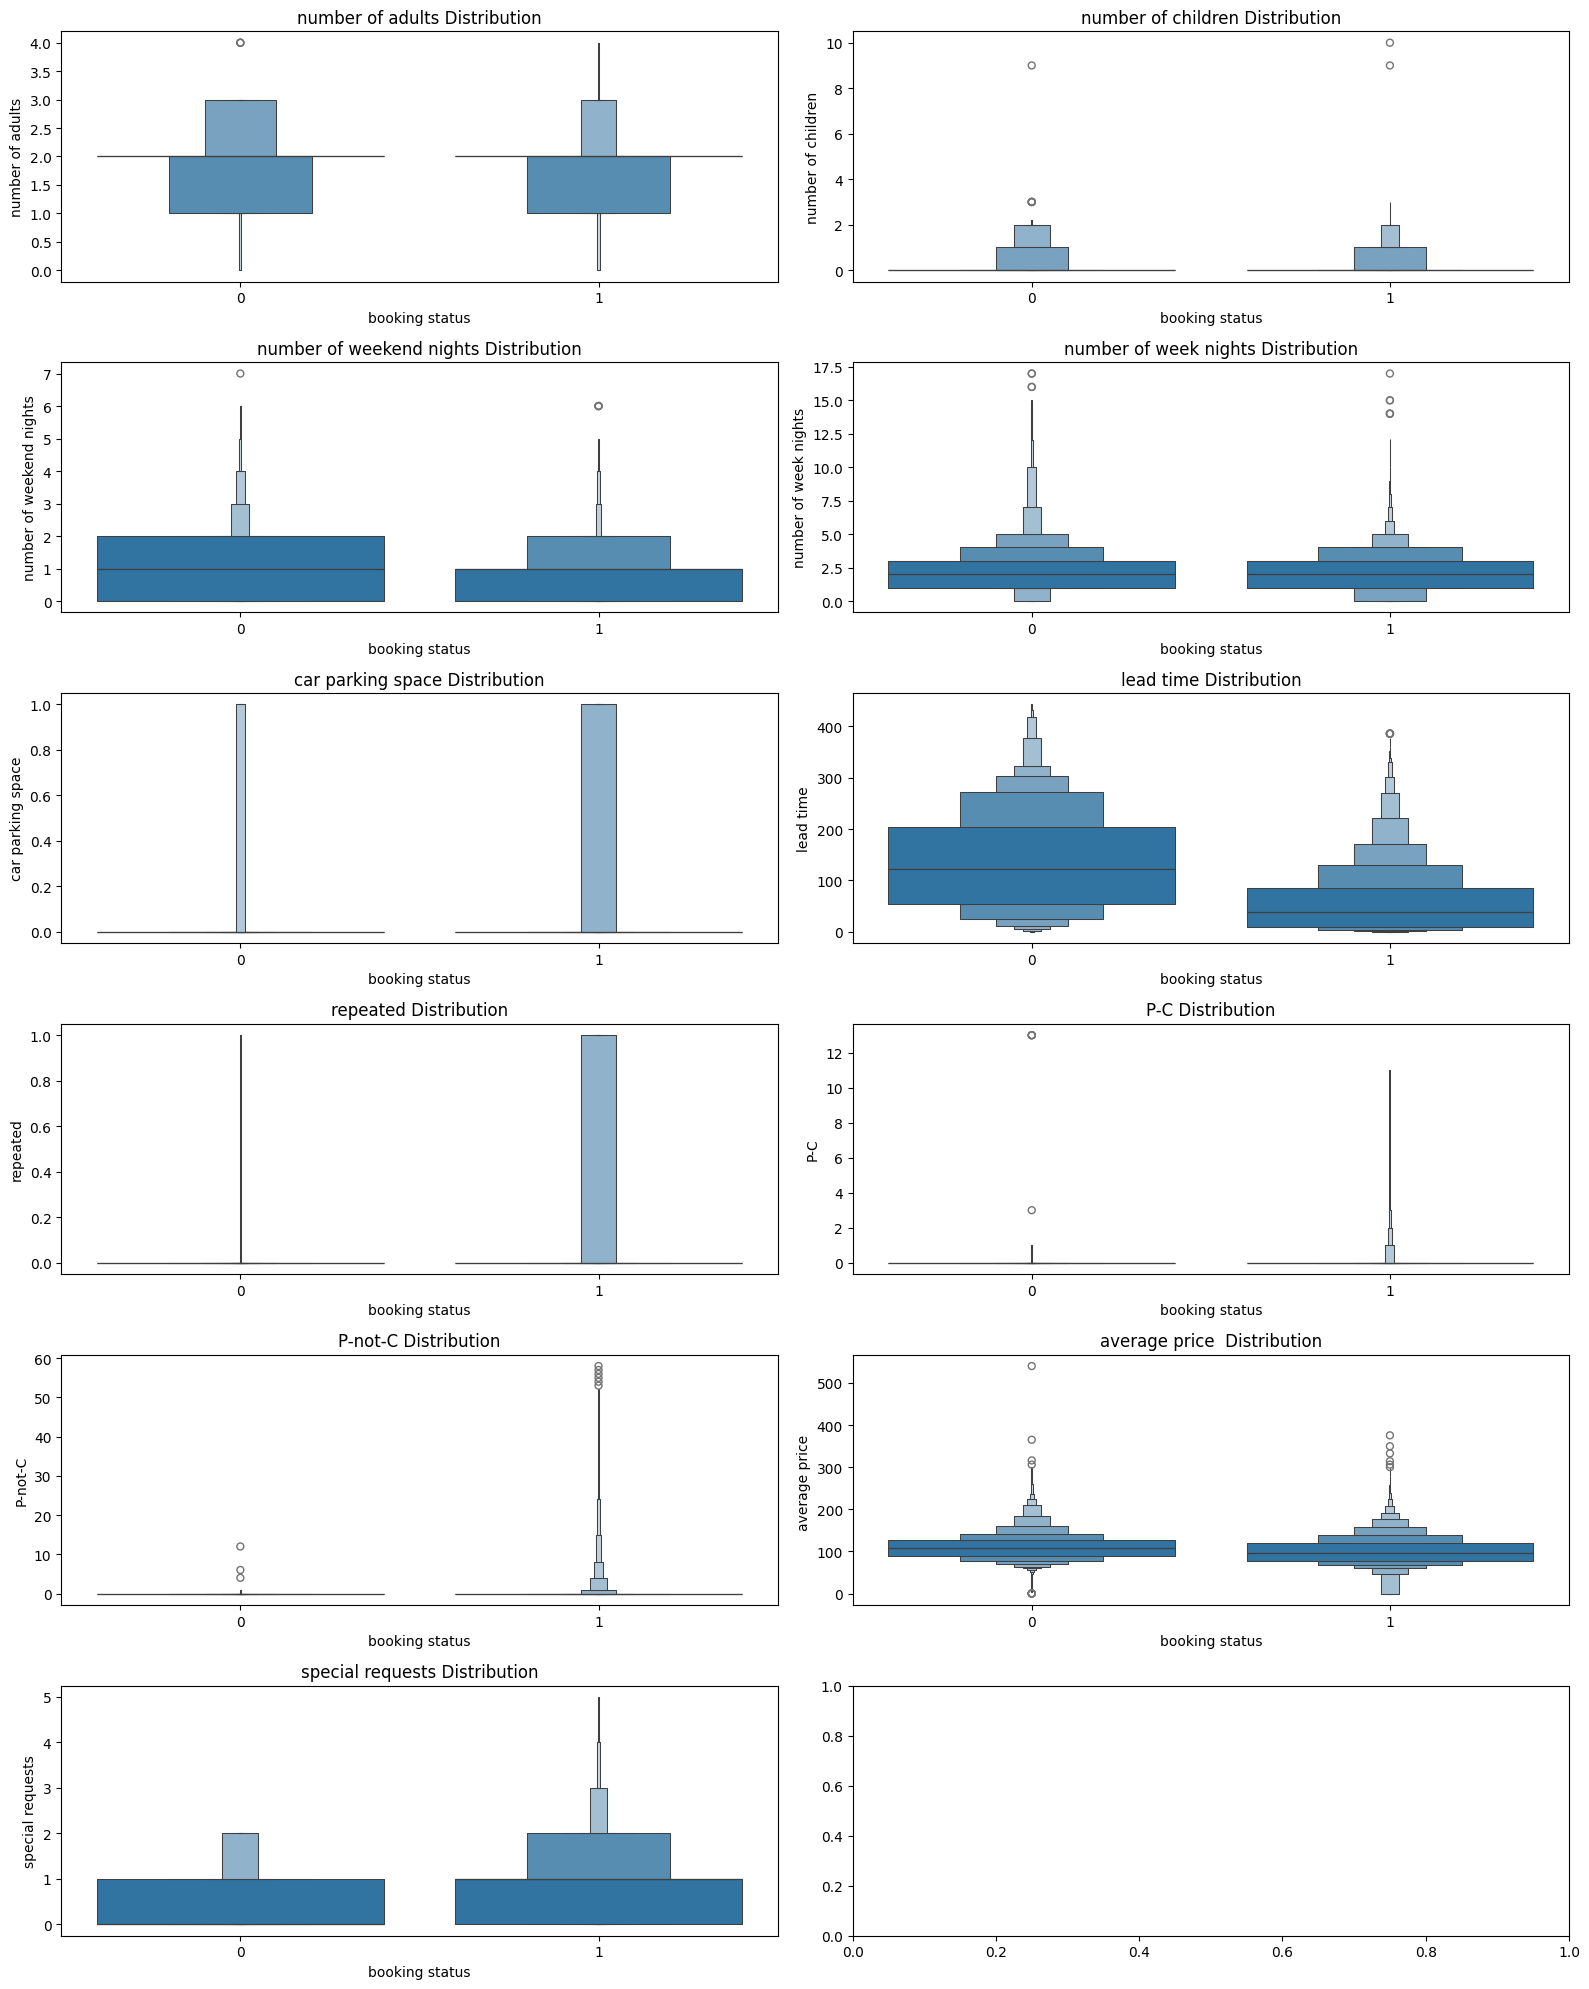

In [13]:
# Check the outliers using boxplot
# Deifne the number of rows and columns
nrows = len(df_num.columns) // 2 + (len(df_num.columns) % 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 20))

# Iterate over the numerical columns and plot boxplots
for idx, column in enumerate(df_num.drop(columns = 'booking status')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxenplot( x='booking status' , y= column , data=df_num, ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel("booking status")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

In [14]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    Q1 = dataframe[column].quantile(q1)
    Q3 = dataframe[column].quantile(q3)
    interquartile_range = Q3 - Q1
    up_limit = Q3 + 1.5 * interquartile_range
    low_limit = Q1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing rows with outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit


In [15]:
# Remove the outliers
print('After removing the outliers :')
for column in (df.select_dtypes(include=['number']).columns):
    replace_with_thresholds(df, column)
    print(f'"{column}" has outliers: {check_outlier(df, column)}')

After removing the outliers :
"number of adults" has outliers: False
"number of children" has outliers: False
"number of weekend nights" has outliers: False
"number of week nights" has outliers: False
"car parking space" has outliers: False
"lead time" has outliers: False
"repeated" has outliers: False
"P-C" has outliers: False
"P-not-C" has outliers: False
"average price " has outliers: False
"special requests" has outliers: False
"booking status" has outliers: False


- lead time column and its values
- Average price column

In [16]:
# Remove the rows that have average price = 0
df_cleaned = df[df['average price '] != 0]

In [17]:
# Sort the data based on date of reservation column
df_sorted = df_cleaned.sort_values(by=['date of reservation'])

# Drop the first two rows
df_cleaned = df_sorted.iloc[2:]

# Drop the non values in the data because of date of reservation
df_cleaned.dropna(inplace=True)

# Reset the index
df_cleaned.reset_index(drop=True, inplace=True)

# Extract the year, month and year from the date column
df_cleaned['year'] = df_cleaned['date of reservation'].dt.year
df_cleaned['month'] = df_cleaned['date of reservation'].dt.month
df_cleaned['day'] = df_cleaned['date of reservation'].dt.day

# Drop the date column
df_cleaned.drop(columns=['date of reservation'], inplace=True)

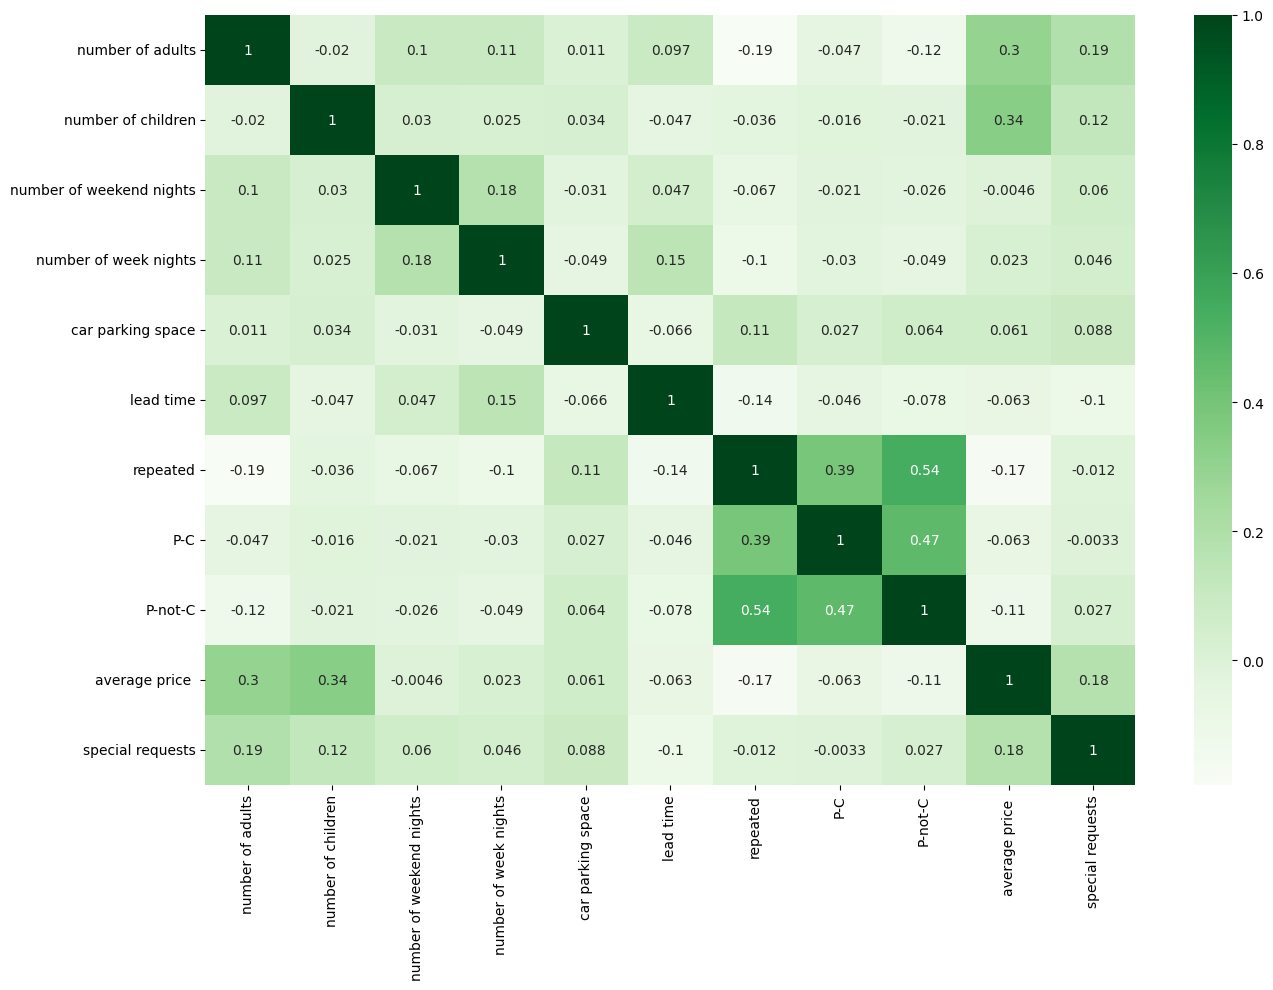

In [18]:
# Checking for the correlation
corr = df_num.drop(columns= 'booking status').corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

- There are no high correlation between the columns

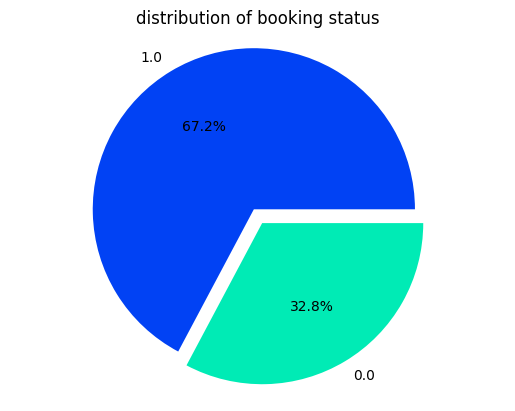

In [19]:
# Target column balance
target_column = df_cleaned['booking status'].value_counts()

# pie chart for target column
plt.pie(target_column, labels = target_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("distribution of booking status")
plt.axis("equal")
plt.show()

**Splitting data for train and test**

In [20]:
X = df_cleaned.drop(columns = 'booking status')
target = df_cleaned['booking status']

X_train , X_test , y_train , y_test = train_test_split(X ,target ,test_size=0.2 , random_state=42, stratify=target)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (28996, 17)
y_train shape: (28996,)
X_test shape: (7250, 17)
y_test shape: (7250,)


# Modeling

In [21]:
# Training function using cross validation
def train(classifier,x_train,y_train,x_test,y_test):

    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 42)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))


# Model evaluation function
def model_evaluation(classifier,x_test,y_test):

    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')

    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

**Random forest**

In [22]:
rf_classifier = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

Cross Validation Score :  95.13%
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      2376
         1.0       0.91      0.94      0.93      4874

    accuracy                           0.90      7250
   macro avg       0.89      0.88      0.88      7250
weighted avg       0.90      0.90      0.90      7250



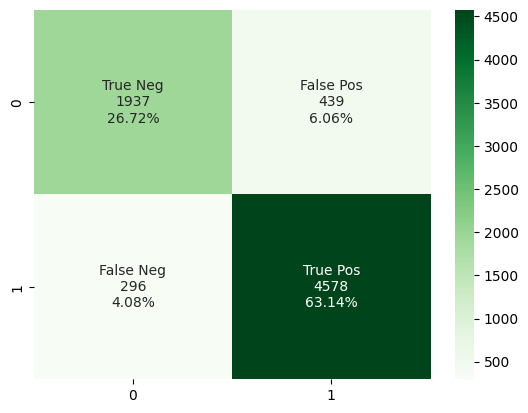

In [23]:
# Training the model
train(rf_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(rf_classifier, X_test, y_test)

In [24]:
# Saving the model
joblib.dump(rf_classifier, 'booking_classifier.pkl')

['booking_classifier.pkl']